In [12]:
import torch
import triton

BLOCK_SIZE = 32
device = torch.device("cuda")

from numba_mm import launch_naive_numba_matmul

In [13]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    launch_naive_numba_matmul(out, a, b, M, N, K, BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [14]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    assert torch.allclose(torch.matmul(a, b), matmul(a, b), atol=5e-4), size

In [15]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['numba', 'torch'],
                             line_names=[
                                 "Numba",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="naive-numba-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'numba':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

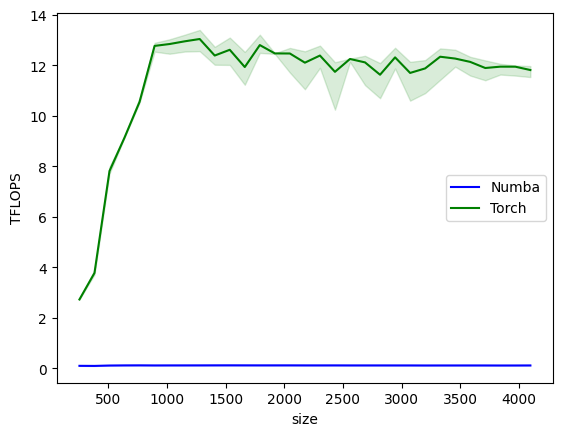

naive-numba-matmul-perf:
      size     Numba      Torch
0    256.0  0.103034   2.730667
1    384.0  0.099759   3.780923
2    512.0  0.115172   7.817901
3    640.0  0.120357   9.142857
4    768.0  0.122337  10.556134
5    896.0  0.118836  12.772073
6   1024.0  0.120084  12.846260
7   1152.0  0.120504  12.952621
8   1280.0  0.121062  13.044586
9   1408.0  0.122493  12.390400
10  1536.0  0.123316  12.617611
11  1664.0  0.122211  11.934897
12  1792.0  0.121389  12.804356
13  1920.0  0.121652  12.474071
14  2048.0  0.121901  12.471014
15  2176.0  0.120586  12.107864
16  2304.0  0.120276  12.389975
17  2432.0  0.120827  11.745177
18  2560.0  0.119415  12.254300
19  2688.0  0.119420  12.118824
20  2816.0  0.119475  11.630358
21  2944.0  0.118966  12.317358
22  3072.0  0.118986  11.701406
23  3200.0  0.117054  11.880143
24  3328.0  0.117857  12.343194
25  3456.0  0.117870  12.270058
26  3584.0  0.118143  12.138170
27  3712.0  0.117743  11.896702
28  3840.0  0.116313  11.949674
29  3968.0  0.1

In [16]:
benchmark.run(show_plots=True, print_data=True)

In [17]:
torch.cuda.empty_cache()